# To run this notebook you need to download the model files hosted on Google drive
If the download code doesn't work, please download the model files from [here](https://drive.google.com/file/d/1QAYvLQUTsgcoqYdjpzlgHYxcqWrlw_Ht/view?usp=sharing).

In [1]:
download_files = True

In [2]:
# import os
# import zipfile
# from zipfile import ZipFile
# import requests

# def download_file_from_google_drive(id, destination):
#     print("Starting download...")
#     URL = "https://docs.google.com/uc?export=download"
#     session = requests.Session()
#     response = session.get(URL, params = { 'id' : id }, stream = True)
#     token = get_confirm_token(response)
#     if token:
#         params = {'id': id, 'confirm': token}
#         response = session.get(URL, params = params, stream = True)
#     save_response_content(response, destination)
#     print("Unzipping file...")
#     unpack_and_remove(destination)
#     print("Finished!")

# def get_confirm_token(response):
#     for key, value in response.cookies.items():
#         if key.startswith('download_warning'):
#             return value
#     return None

# def save_response_content(response, destination):
#     chunk_size = 32768
#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(chunk_size):
#             if chunk:
#                 f.write(chunk)

# def unpack_and_remove(destination):
#     file_content = zipfile.ZipFile(destination)
#     file_content.extractall()
#     file_content.close()
#     os.remove(destination)

# if download_files:
#     file_id = '1QAYvLQUTsgcoqYdjpzlgHYxcqWrlw_Ht'
#     destination = './all_model_files.zip'
#     download_file_from_google_drive(file_id, destination)

In [3]:
import os
import sys
import h5py
import numpy as np
import shutil
import pandas as pd

import torch
from torch.utils.data import DataLoader
import math
import tqdm
import random
import imageio

import multiprocessing
from torchvision.utils import make_grid
from PIL import Image
import ast
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import resize
from torchvision.utils import save_image

import requests
from PIL import ImageDraw
from PIL import ImageFont
from io import BytesIO
import IPython.display
from IPython.display import HTML
import matplotlib.pyplot as plt
from shutil import copyfile
import IPython.display as IPython_display

from pytorch_fid.fid_score import calculate_fid_given_paths
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [4]:
from resnet_classifier import ResNet
from mobilenet_classifier import MobileNet

# Important! Choose the model and classifier you want to use here

In [5]:
model_names = {"plant", "faces_old", "faces_new", "ProstateCa"}
model_to_use = "faces_new"

In [6]:
# Threshold should be 501 for the new faces model
stylex_path = None
classifier_name = None
data = None
USE_OLD_ARCHITECTURE = False
hf = None # hdf5 file.
shift_size = 1
threshold_index = 101

if model_to_use == "plant":
    stylex_path = "models/old_plant_mobilenet/model_260.pt"
    data = "../data/plant_village/all" # Plant dataset
    classifier_name = "mobilenet-64px-plant.pt" # Only use mobilenet for plants
    hf = h5py.File("./precomputed_attfind_files/style_change_records_old_plants.hdf5", 'r')
    threshold_index = 101
    shift_size = 2
    USE_OLD_ARCHITECTURE = True

elif model_to_use == "faces_old":
    stylex_path = "/code/ProstateCa/Explaining-In-Style-Reproducibility-Study/stylex/models/old_faces_gender_mobilenet/model_134.pt"
    data = "../data/Kaggle_FFHQ_Resized_256px/flickrfaceshq-dataset-nvidia-resized-256px/resized" # FFHQ faces dataset
    classifier_name = "/code/ProstateCa/Explaining-In-Style-Reproducibility-Study/stylex/resnet-18-64px-gender-classifier.pt"  # Use ResNet for all the gender related ones, even the one trained on mobilenet
    hf = h5py.File("./precomputed_attfind_files/style_change_records_old_faces.hdf5", 'r')
    threshold_index = 101
    shift_size = 2
    USE_OLD_ARCHITECTURE = True

elif model_to_use == "faces_new":
    stylex_path = "/code/ProstateCa/ProjectedEx/models/FFHQ/model_184.pt"
    data = "/code/ProstateCa/ProjectedEx/data/Kaggle_FFHQ_Resized_256px/flickrfaceshq-dataset-nvidia-resized-256px/resized" # FFHQ faces dataset
    classifier_name = "/code/ProstateCa/asset/v1/resnet-18-64px-gender-classifier.pt"  # Use ResNet for all the gender related ones, even the one trained on mobilenet
    USE_OLD_ARCHITECTURE = True
    hf = h5py.File("/code/ProstateCa/ProjectedEx/style_change_records.hdf5", 'r')
    threshold_index = 501
    shift_size = 1
    USE_OLD_ARCHITECTURE = True

elif model_to_use == "ProstateCa":
    stylex_path = "/code/ProstateCa/asset/v1/models/prostateca-dwi/model_79.pt"
    data = "/code/ProstateCa/dwi_crop" # FFHQ faces dataset
    classifier_name = "/code/ProstateCa/asset/v1/saved_models/dwi_resnet18.pth"  # Use ResNet for all the gender related ones, even the one trained on mobilenet
    hf = h5py.File("/code/ProstateCa/ProstateCa/stylex/style_change_records.hdf5", 'r')
    threshold_index = 501
    shift_size = 1
    USE_OLD_ARCHITECTURE = True


if USE_OLD_ARCHITECTURE:
    from stylex_train import StylEx, Dataset, DistributedSampler, MNIST_1vA
    from stylex_train import image_noise, styles_def_to_tensor, make_weights_for_balanced_classes, cycle, default
else:
    from stylex_train_new import StylEx, Dataset, DistributedSampler, MNIST_1vA
    from stylex_train_new import image_noise, styles_def_to_tensor, make_weights_for_balanced_classes, cycle, default

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/conda/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [7]:
def load_hdf5_results(data_file, name, threshold):
    return np.array(data_file[name])[0:threshold]

def model_loader(stylex_path,
                   classifier_name,
                   image_size,
                   cuda_rank):

    init_stylex = StylEx(image_size=image_size, transparent=False)
    init_stylex.load_state_dict(torch.load(stylex_path)["StylEx"])

    init_classifier = None

    if "mobilenet" in classifier_name.lower():
        init_classifier = MobileNet(classifier_name, cuda_rank=cuda_rank, output_size=2, image_size=image_size)
    elif "resnet" in classifier_name.lower():
        init_classifier = ResNet(classifier_name, cuda_rank=cuda_rank, output_size=2, image_size=image_size)
    else:
        raise NotImplementedError("This classifier is not supported yet, please add support or change the filename to contain MobileNet or ResNet.")
    return init_stylex, init_classifier

def sindex_to_block_idx_and_index(generator, sindex):
    tmp_idx = sindex

    block_idx = None
    idx = None

    for idx, block in enumerate(generator.blocks):
        if tmp_idx < block.num_style_coords:
            block_idx = idx
            idx = tmp_idx
            break
        else:
            tmp_idx = tmp_idx - block.num_style_coords

    return block_idx, idx

def plot_image(tensor, upscale_res=None):
    if upscale_res is not None:
        tensor = resize(tensor, upscale_res)
    grid = make_grid(tensor,nrow=5)
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    display(im)

In [8]:
font_path = "./Roboto-Bold.ttf"

# Download font if it doesn't exist
if not os.path.exists(font_path):
  r = requests.get('https://github.com/openmaptiles/fonts/raw/master/roboto/Roboto-Bold.ttf')
  open(font_path, 'wb').write(r.content)

results_folder = './'
threshold_folder = './'
dataset_name = None # for any dataset that is not MNIST
cuda_rank = 0

# **Load the file**

In [9]:
style_change_effect = load_hdf5_results(hf, "style_change", threshold_index)
W_values = load_hdf5_results(hf, "latents", threshold_index)
base_probs = load_hdf5_results(hf, "base_prob", threshold_index)
all_style_vectors = load_hdf5_results(hf, "style_coordinates", threshold_index)
original_images = load_hdf5_results(hf, "original_images", threshold_index)
discriminator_results = load_hdf5_results(hf, "discriminator", threshold_index)

saved_noise = torch.Tensor(np.array(hf["noise"])).cuda(cuda_rank)
style_min = torch.Tensor(np.squeeze(np.array(hf["minima"])))
style_max = torch.Tensor(np.squeeze(np.array(hf["maxima"])))

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - np.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = np.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors

style_min = style_min.cuda(cuda_rank)
style_max = style_max.cuda(cuda_rank)

In [10]:
num_style_coords = len(style_min)
image_size = original_images.shape[-1]
batch_size = 1

In [11]:
stylex, classifier = model_loader(stylex_path = stylex_path,
                                  classifier_name = classifier_name,
                                  image_size = image_size,
                                  cuda_rank = cuda_rank)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Laying the foundation**

In [12]:
all_labels = np.argmax(base_probs, axis=1)
style_effect_classes = {}
W_classes = {}
style_vectors_distances_classes = {}
all_style_vectors_classes = {}

for img_ind in range(2):
    
    img_inx = np.array([i for i in range(all_labels.shape[0]) if all_labels[i] == img_ind])
    curr_style_effect = np.zeros((len(img_inx), style_change_effect.shape[1], style_change_effect.shape[2], style_change_effect.shape[3]))
    curr_w = np.zeros((len(img_inx), W_values.shape[1]))
    curr_style_vector_distances = np.zeros((len(img_inx), style_change_effect.shape[2], 2))
    
    for k, i in enumerate(img_inx):
        curr_style_effect[k, :, :] = style_change_effect[i, :, :, :]
        curr_w[k, :] = W_values[i, :]
        curr_style_vector_distances[k, :, :] = all_style_vectors_distances[i, :, :]
        
    style_effect_classes[img_ind] = curr_style_effect
    W_classes[img_ind] = curr_w
    style_vectors_distances_classes[img_ind] = curr_style_vector_distances
    all_style_vectors_classes[img_ind] = all_style_vectors[img_inx]
    print(f'Class {img_ind}, {len(img_inx)} images.')

Class 0, 1 images.
Class 1, 9 images.


In [13]:
def find_significant_styles(style_change_effect,
                            num_indices,
                            class_index,
                            generator,
                            classifier,
                            all_dlatents,
                            style_min,
                            style_max,
                            max_image_effect = 0.2,
                            label_size = 2,
                            sindex_offset = 0):
  
    num_images = style_change_effect.shape[0]
    style_effect_direction = np.maximum(0, style_change_effect[:, :, :, class_index].reshape((num_images, -1)))

    images_effect = np.zeros(num_images)
    all_sindices = []
    discriminator_removed = []

    while len(all_sindices) < num_indices:
        next_s = np.argmax(np.mean(style_effect_direction[images_effect < max_image_effect], axis=0))
        
        all_sindices.append(next_s)
        images_effect += style_effect_direction[:, next_s]
        style_effect_direction[:, next_s] = 0

    return [(x // style_change_effect.shape[2], (x % style_change_effect.shape[2]) + sindex_offset) for x in all_sindices]

In [14]:
label_size_clasifier = 2
num_indices =  4
effect_threshold = 0.5
s_indices_and_signs_dict = {}

for class_index in [0, 1]:
    split_ind =  class_index #1 - class_index
    all_s = style_effect_classes[split_ind]
    all_w = W_classes[split_ind]

    # Find s indicies
    s_indices_and_signs = find_significant_styles(style_change_effect=all_s,
                                                  num_indices=num_indices,
                                                  class_index=class_index,
                                                  generator=stylex.G,
                                                  classifier=classifier,
                                                  all_dlatents=all_w,
                                                  style_min=style_min,
                                                  style_max=style_max,
                                                  max_image_effect=effect_threshold*5,
                                                  label_size=label_size_clasifier,
                                                  sindex_offset=0)

    s_indices_and_signs_dict[class_index] = s_indices_and_signs

sindex_class_0 = [sindex for _, sindex in s_indices_and_signs_dict[0]]
all_sindex_joined_class_0 = [(1 - direction, sindex) for direction, sindex in s_indices_and_signs_dict[1] if sindex not in sindex_class_0]
all_sindex_joined_class_0 += s_indices_and_signs_dict[0]
scores = []

for direction, sindex in all_sindex_joined_class_0:
    other_direction = 1 if direction == 0 else 0
    curr_score = np.mean(style_change_effect[:, direction, sindex, 0]) + np.mean(style_change_effect[:, other_direction, sindex, 1])
    scores.append(curr_score)


s_indices_and_signs = [all_sindex_joined_class_0[i] for i in np.argsort(scores)[::-1]]
#s_indices_and_signs = [i for i in s_indices_and_signs if i[0] != 0 and i[1] != 0]

print('Directions and style indices for moving from class 1 to class 0 = ', s_indices_and_signs[:num_indices])
print('Use the other direction to move from class 0 to 1.')

Directions and style indices for moving from class 1 to class 0 =  [(0, 2104), (1, 1014), (1, 1675), (1, 939)]
Use the other direction to move from class 0 to 1.


In [15]:
def generate_user_study_img(tensor, upscale_res=None, nrow=2) -> None:
    changed_tensor = tensor.clone()
    if upscale_res is not None:
        changed_tensor = resize(changed_tensor, upscale_res)
    grid = make_grid(changed_tensor, nrow=nrow)
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)

    return im

def get_images(dlatent,
                generator,
                classifier,
                sindex,
                s_style_min,
                s_style_max,
                style_direction_index,
                shift_size,
                label_size,
                noise, 
                cuda_rank):
    
    with torch.no_grad():
        dlatent = [(torch.unsqueeze(torch.Tensor(dlatent).cuda(cuda_rank), 0), 5)]
        w_latent_tensor = styles_def_to_tensor(dlatent)
        generated_image, style_coords = generator(w_latent_tensor, noise, get_style_coords=True)
        base_prob = torch.softmax(classifier.classify_images(generated_image), dim=1)[0]

        block_idx, weight_idx = sindex_to_block_idx_and_index(generator, sindex)
        block = generator.blocks[block_idx]

        current_style_layer = None
        one_hot = None

        if weight_idx < block.input_channels:
            current_style_layer = block.to_style1
            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
        else:
            weight_idx -= block.input_channels
            current_style_layer = block.to_style2
            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

        one_hot[:, weight_idx] = 1


        if style_direction_index == 0:
            shift = one_hot * ((s_style_min - style_coords[:, sindex]) * shift_size).unsqueeze(1)
        else:
            shift = one_hot * ((s_style_max - style_coords[:, sindex]) * shift_size).unsqueeze(1)

        shift = shift.squeeze(0)
        current_style_layer.bias += shift
        changed_image, _ = generator(w_latent_tensor, noise, get_style_coords=True)
        changed_prob = torch.softmax(classifier.classify_images(changed_image), dim=1)[0]
        current_style_layer.bias -= shift
    
    return generated_image, changed_image, base_prob, changed_prob

# **Match the change**

In [16]:
def user_study1(stylex,
                classifier,
                gender,
                top_attribute,
                other_attribute,
                s_indices_and_signs,
                base_probs,
                W_values,
                style_min,
                style_max,
                shift_size,
                label_size,
                noise,
                cuda_rank,
                upscale_res):

    if other_attribute >= len(s_indices_and_signs):
        raise ValueError("That attribute is not included in the attribute list, it only includes %s images" % len(s_indices_and_signs))
    if gender == "male" or gender == "female":
        gender_index = 0 if gender == "male" else 1
    else:
        raise ValueError("Please use either the male or female gender")
    
    gender_indices = list(np.where(np.argmax(base_probs, axis=1) == gender_index)[0])
    image_ids = random.sample(gender_indices, 4)
    four_latents = W_values[image_ids]
    
    indices_and_signs = np.array([s_indices_and_signs[top_attribute]]*2 + random.sample([s_indices_and_signs[top_attribute],
                                                                                s_indices_and_signs[other_attribute]], 2))
    indices_and_signs = indices_and_signs[[0,2,1,3]]

    g_images = []
    c_images = []
    
    for index in range(4):
        direction_index, style_index = indices_and_signs[index]
        if gender_index == 0:
            style_direction = 1 if direction_index == 0 else 0
        else:
            style_direction = direction_index
        
        generated_image, changed_image, _, _ = get_images(four_latents[index],
                                                    stylex.G,
                                                    classifier,
                                                    style_index,
                                                    style_min[style_index],
                                                    style_max[style_index],
                                                    style_direction,
                                                    shift_size,
                                                    label_size,
                                                    noise,
                                                    cuda_rank)
        g_images.append(generated_image)
        c_images.append(changed_image)
        
    g_images = torch.cat(g_images)
    c_images = torch.cat(c_images)
        
    if upscale_res != None:
        g_images = generate_user_study_img(g_images, upscale_res=upscale_res, nrow=2)
        c_images = generate_user_study_img(c_images, upscale_res=upscale_res, nrow=2)
            
    return [g_images, c_images], indices_and_signs

In [17]:
top_k_range = 4
# Render the images
images_to_save = []
info_of_images = []
unique_attributes = list(range(top_k_range))
random.shuffle(unique_attributes)
for top_attribute in range(top_k_range):
    gender = "male" if top_attribute % 2 == 0 else "female" 
    
    for index, attr in enumerate(unique_attributes):
        if attr != top_attribute:
            other_attribute = unique_attributes.pop(index)
            break
    
    images_to_render, attribute_info = user_study1(stylex = stylex,
                                        classifier = classifier,
                                        gender = gender,
                                        top_attribute = top_attribute,
                                        other_attribute = other_attribute,
                                        s_indices_and_signs = s_indices_and_signs,
                                        base_probs = base_probs,
                                        W_values = W_values,
                                        style_min = style_min,
                                        style_max = style_max,
                                        shift_size = shift_size,
                                        label_size = 2,
                                        noise = saved_noise,
                                        cuda_rank = cuda_rank,
                                        upscale_res=512)
    
    images_to_save.append(images_to_render)
    info_of_images.append((attribute_info, (top_attribute, other_attribute)))

ValueError: Sample larger than population or is negative

In [18]:
from PIL import Image, ImageFont, ImageDraw
import IPython.display as IPython_display

# Save the images of user study 1 to disk
# Check if user study directory exists, if not, create it
user_study_dir = "./user_study_images"
user_study1_dir = os.path.join(user_study_dir, "study_1")
user_study2_dir = os.path.join(user_study_dir, "study_2")

if not os.path.exists(user_study_dir):
    os.makedirs(user_study_dir)

    # Make a directory for each user study
    os.makedirs(user_study1_dir)
    os.makedirs(user_study2_dir)

for index, (images, _) in enumerate(zip(images_to_save, info_of_images)):
    file_path = os.path.join(user_study1_dir, f"class_study_{index}.gif")
    imageio.mimsave(file_path, images, fps=1 + 1/3)
    display(IPython_display.Image(filename=file_path))

# Save the info_of_images to a text file
with open(os.path.join(user_study1_dir, "info_of_images.txt"), "w") as f:
    for directions_and_sindex, chosen_attributes in info_of_images:
        target_attr = directions_and_sindex[0]
        correct_answer = "top-right" if (target_attr == directions_and_sindex[1]).all() else "bottom-right"
        f.write(f"Same transformation in {correct_answer} \n {chosen_attributes} \n {str(directions_and_sindex)} \n\n")

# **Describe the change**

In [19]:
def user_study2(stylex,
                classifier,
                top_attribute,
                s_indices_and_signs,
                W_values,
                style_min,
                style_max,
                shift_size,
                label_size,
                noise,
                cuda_rank,
                upscale_res):
    
    image_ids = random.sample(range(len(W_values)), 4)
    four_latents = W_values[image_ids]
    
    indices_and_signs = np.array([s_indices_and_signs[top_attribute]] * 4)
    indices_and_signs = indices_and_signs[[0,2,1,3]]

    g_images = []
    c_images = []
    
    for index in range(4):
        style_direction, style_index = indices_and_signs[index]

        
        generated_image, changed_image, _, _ = get_images(four_latents[index],
                                                    stylex.G,
                                                    classifier,
                                                    style_index,
                                                    style_min[style_index],
                                                    style_max[style_index],
                                                    style_direction,
                                                    shift_size,
                                                    label_size,
                                                    noise,
                                                    cuda_rank)

        g_images.append(generated_image)
        c_images.append(changed_image)
        
    g_images = torch.cat(g_images)
    c_images = torch.cat(c_images)
        
    if upscale_res != None:
        g_images = generate_user_study_img(g_images, upscale_res=upscale_res, nrow=4)
        c_images = generate_user_study_img(c_images, upscale_res=upscale_res, nrow=4)
            
    return [g_images, c_images]

In [20]:
top_k_range = 4
# Render the images
images_to_save = []
for top_attribute in range(top_k_range):
    images_to_render = user_study2(stylex = stylex,
                                    classifier = classifier,
                                    top_attribute = top_attribute,
                                    s_indices_and_signs = s_indices_and_signs,
                                    W_values = W_values,
                                    style_min = style_min,
                                    style_max = style_max,
                                    shift_size = shift_size,
                                    label_size = 2,
                                    noise = saved_noise,
                                    cuda_rank = cuda_rank,
                                    upscale_res=512)
    
    images_to_save.append(images_to_render)

/opt/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


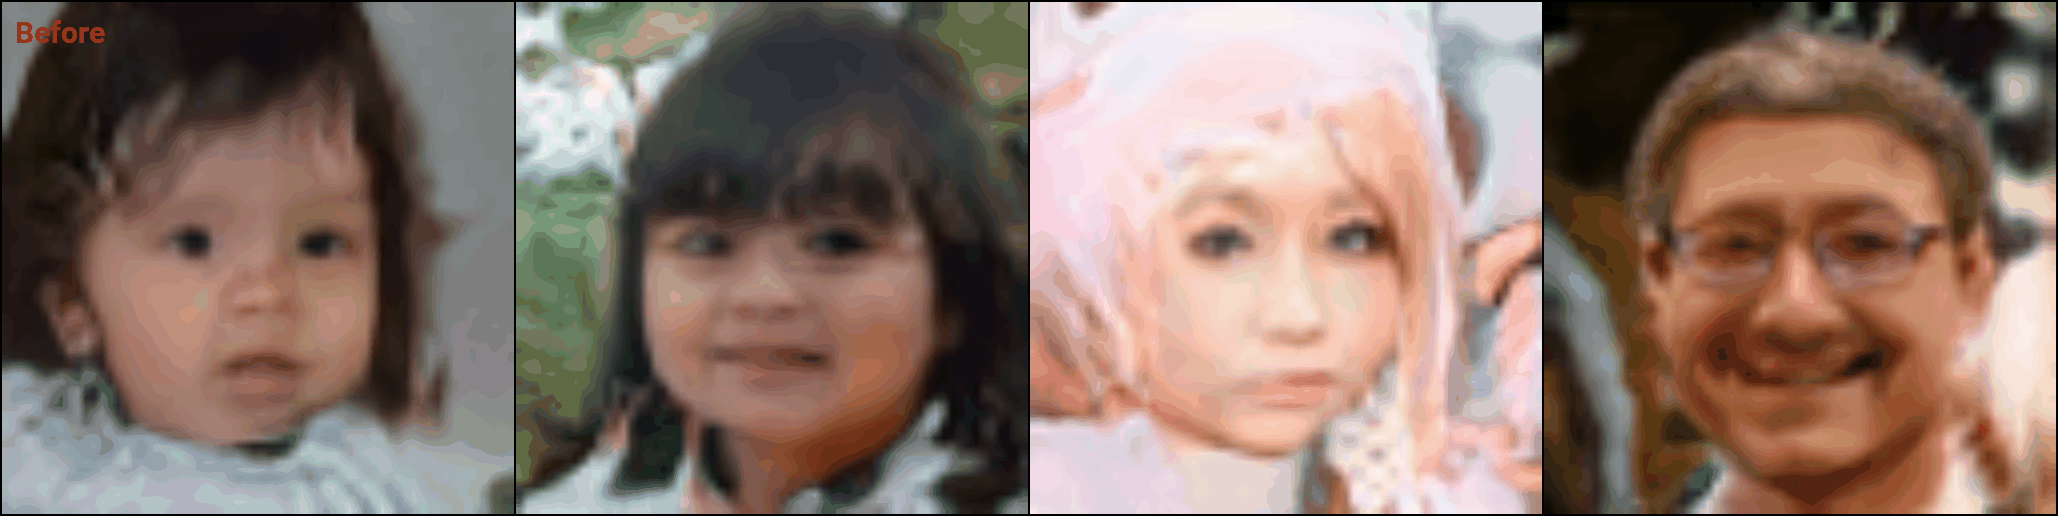

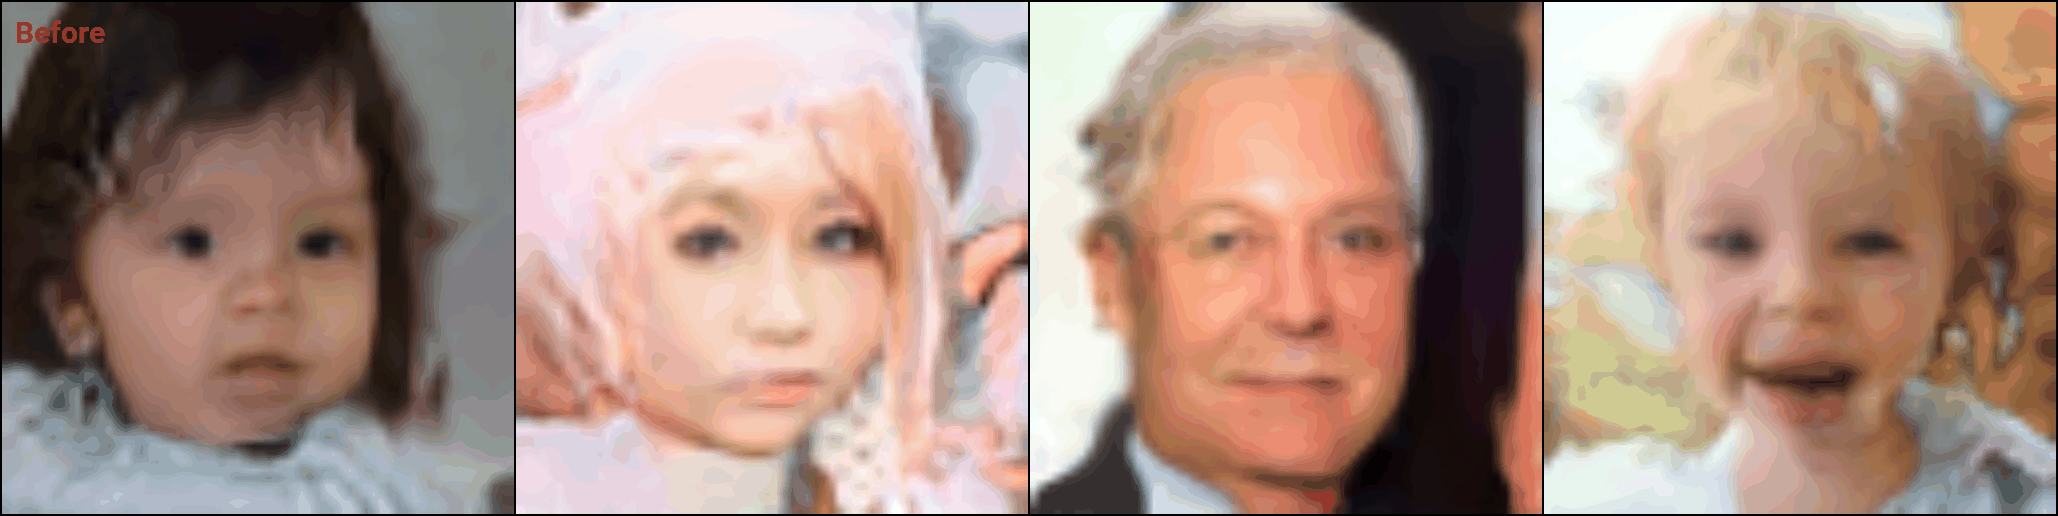

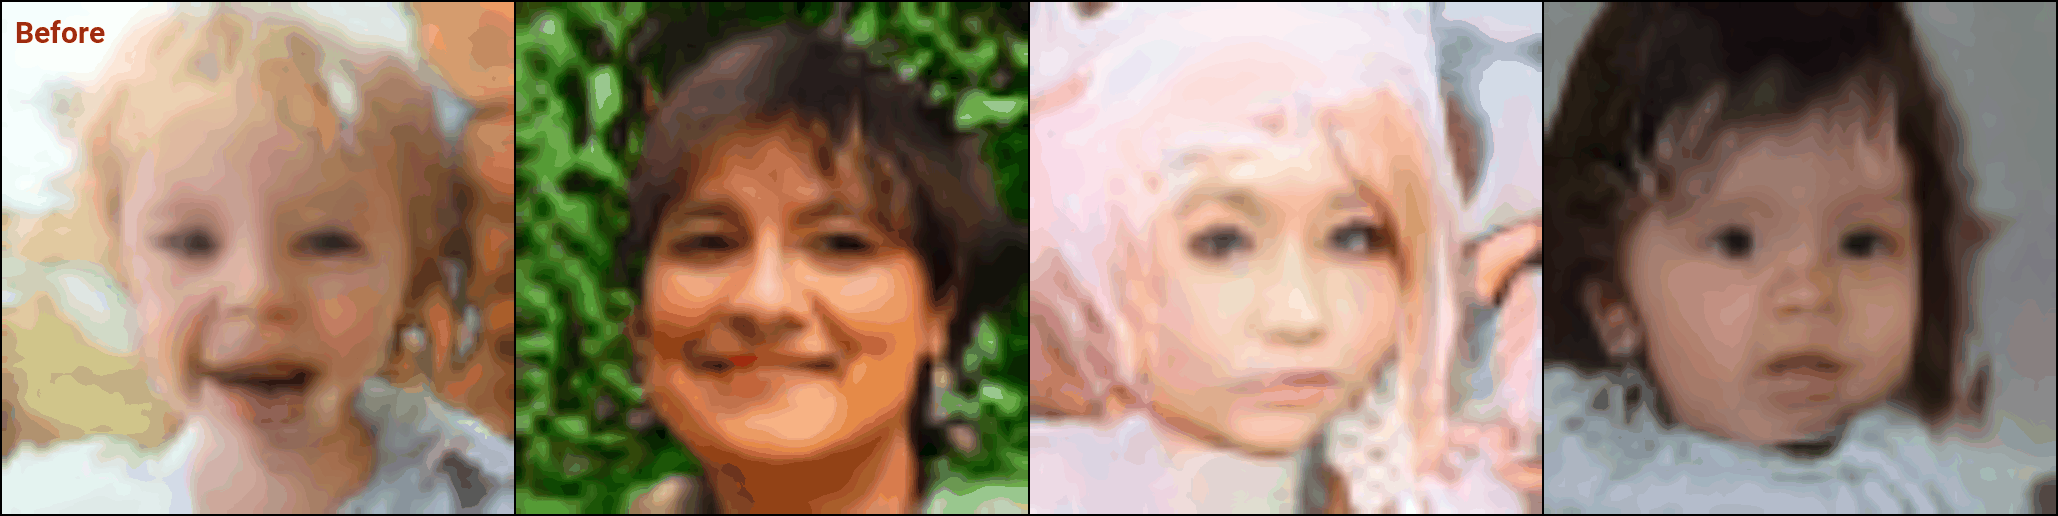

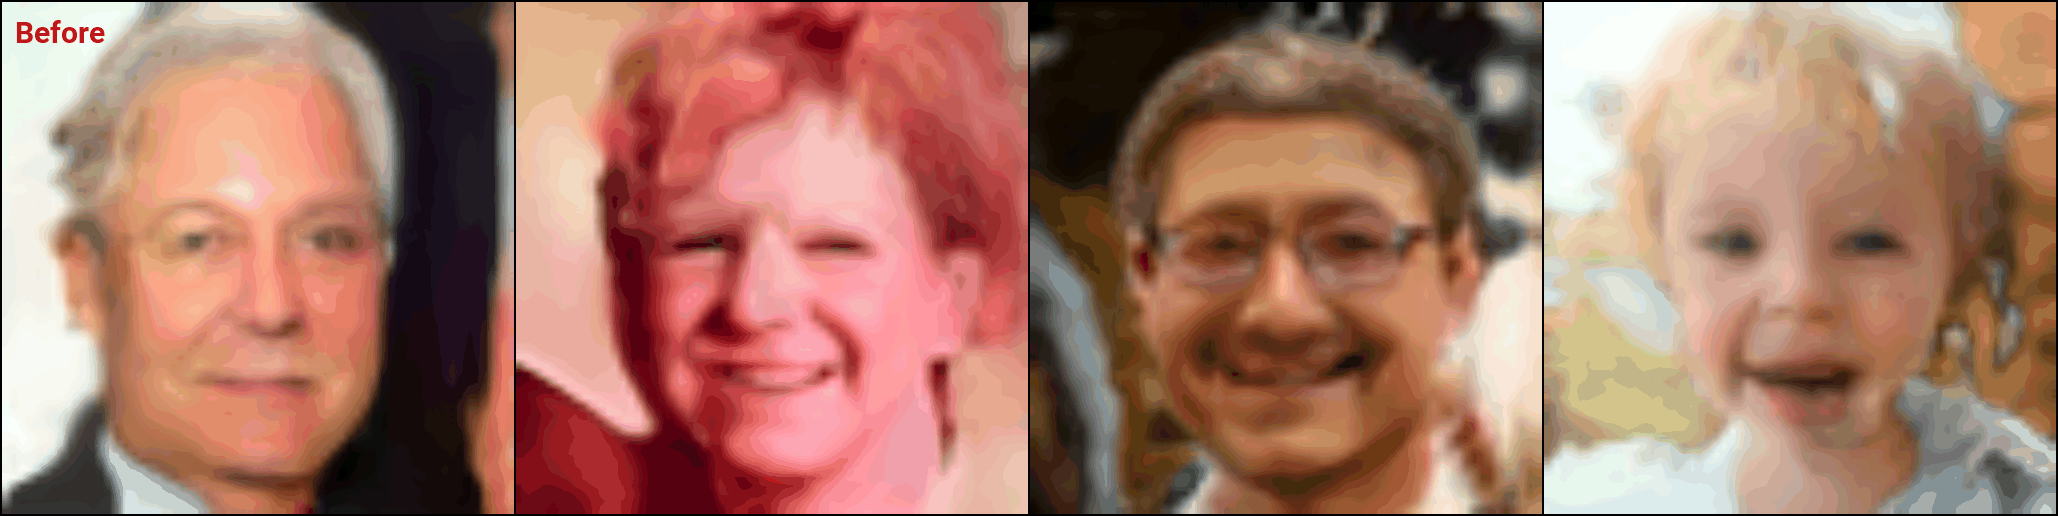

In [21]:
from PIL import Image, ImageFont, ImageDraw

for index, image_to_render in enumerate(images_to_save):
    for image, text in zip(image_to_render, ["Before", "After"]):
        font = ImageFont.truetype(font_path, size=30)
        image_editable = ImageDraw.Draw(image)
        image_editable.text((15,15), text, (255, 0, 0), font=font)
    
    file_path = os.path.join(user_study2_dir, f"verbal_study_{index}.gif")
    imageio.mimsave(file_path, image_to_render, fps=1)
    display(IPython_display.Image(filename=file_path))

# **Show top attributes**

In [22]:
def show_top_attributes(stylex,
                    classifier,
                    s_indices_and_signs,
                    W_values,
                    style_change_effect,
                    base_probs,
                    style_min,
                    style_max,
                    noise,
                    top_attribute_dir,
                    upscale_res = 128,
                    cuda_rank = 0,
                    label_size = 2,
                    shift_size = 2,
                    random_images = True,
                    indices = None,
                    return_probabilities = False,
                    stylex_path = None):
    
    for attribute in range(4):
        direction_index, style_index = s_indices_and_signs[attribute]

        if not random_images:
            max_indices = []

            for gender_index in [1,0]:
                if gender_index == 0:
                    direction = 1 if direction_index == 0 else 0
                else:
                    direction = direction_index


                gender_indices = list(np.where(np.argmax(base_probs, axis=1) == gender_index)[0])

                max_index = 0
                max_change_effect = float('-inf')

                for index in gender_indices:

                    _, _, base_prob, changed_prob = get_images(np.squeeze(W_values[index]),
                                                        stylex.G,
                                                        classifier,
                                                        style_index,
                                                        style_min[style_index],
                                                        style_max[style_index],
                                                        direction,
                                                        shift_size,
                                                        label_size,
                                                        noise,
                                                        cuda_rank)

                    prob_effect = (base_prob-changed_prob)[gender_index].cpu().detach().numpy()

                    if prob_effect > max_change_effect:
                        max_index = index
                        max_change_effect = prob_effect

                max_indices.append(max_index)

            female_index, male_index = max_indices

        if random_images:
            female_index = random.sample(list(np.where(np.argmax(base_probs, axis=1) == 1)[0]), 1)[0]
            male_index = random.sample(list(np.where(np.argmax(base_probs, axis=1) == 0)[0]), 1)[0]

        elif indices != None:
            female_index, male_index = indices

        female_latent = np.squeeze(W_values[female_index])
        male_latent = np.squeeze(W_values[male_index])

        images = []
        probabilities = []

        for gender_index, latent in enumerate([male_latent, female_latent]):
            if gender_index == 0:
                style_direction = 1 if direction_index == 0 else 0
            else:
                style_direction = direction_index

            generated_image, changed_image, base_prob, changed_prob = get_images(latent,
                                                        stylex.G,
                                                        classifier,
                                                        style_index,
                                                        style_min[style_index],
                                                        style_max[style_index],
                                                        style_direction,
                                                        shift_size,
                                                        label_size,
                                                        noise,
                                                        cuda_rank)

            if return_probabilities:
                probabilities.append(base_prob[0].item())
                probabilities.append(changed_prob[0].item())

            images.append(generated_image)
            images.append(changed_image)

        if return_probabilities:
            create_figure(images, None, top_attribute_dir, probabilities, attribute=attribute, stylex_path=stylex_path)
        else:
            create_figure(images, None, top_attribute_dir, None, attribute=attribute, stylex_path=stylex_path)
    
    return images, probabilities

In [26]:
def image_from_tensor(image, location, upscale_res):
    size = 8
    image = image[0].cpu().detach()
    if upscale_res != None:
        image = resize(image, upscale_res)
    print(image.shape)
    image_transposed = np.transpose(image, [1, 2, 0])
    if location != None:
        x, y = location[0], location[1]
        zoomed = image[:, y-size:y+size, x-size:x+size]
        zoomed = np.resize(zoomed, (3, size*2, size*2))
        zoomed = np.transpose(zoomed, [1, 2, 0])
        return image_transposed, zoomed
    return image_transposed

In [37]:
def create_figure(images_to_render, location, top_attribute_dir, probs=None, attribute=None, stylex_path=None):
    
    dataset_jargon = ["undefined"] * 4
    
    # Change attribute names
    attributes = ['("Undefined")'] * 4
    if "old_faces" in stylex_path.lower():
        # attributes = ['("Eyebrow Thickness")', '("Facial hair")', '("Eye Shadow")', '("Mouth/Smile")']
        dataset_jargon = ["facial", "More Female", "More Male"]
    if "old_plant" in stylex_path.lower():
        # attributes = ['("Blight middle of leaf")', '("Rot/spots edge of leaf")', '("Texture")', '("Shadow")']
        dataset_jargon = ["plant", "Sicker", "Healthier"]
    if "new_faces" in stylex_path.lower():
        # attributes = ['("Unknown")', '("Unknown")', '("Unknown")', '("Unknown")']
        dataset_jargon = ["facial", "More Female", "More Male"]
    
    if "prostateca" in stylex_path.lower():
        # attributes = ['("Unknown")', '("Unknown")', '("Unknown")', '("Unknown")']
        # dataset_jargon = ["facial", "Higher Risk", "Lower Risk"]
        dataset_jargon = ["facial", "More Female", "More Male"]
        
    
    if attribute > 3:
        raise ValueError("Currently it is not supported to plot attributes outside of the top 4")
    
    if attribute != None:
        title = "Attribute #" + str(attribute+1) + "\n" + attributes[attribute]
    else:
        title = f"What {dataset_jargon[0]} attribute changed?"
    
    fig = plt.figure(figsize=(8,8))
    plt.annotate('', xy=(-0.05, 0.30), xycoords='axes fraction', xytext=(-0.05, 0.70), arrowprops=dict(arrowstyle="<->, head_width=0.75", linewidth = 2, color='black'))
    plt.title(title, y=-0.15, fontsize=18)
    plt.text(-0.05, 0.85, f'Perceived \n {dataset_jargon[1]}', horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=15)
    plt.text(-0.05, 0.15, f'  Perceived \n {dataset_jargon[2]}', horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=15)
    plt.axis("off")
    ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
    ax = [ax[3], ax[1], ax[0], ax[2]]
    
    for count, a in enumerate(ax):
        if location != None:
            print(count)
            image, zoomed = image_from_tensor(images_to_render[count], location, None)
        else:
            image = image_from_tensor(images_to_render[count], location, None)

        if (count+1) % 2 == 0:
            a.set_yticklabels([])
            a.set_xticklabels([])
            a.tick_params(left=False)
            a.tick_params(bottom=False)
            for axis in ['top','bottom','left','right']:
                a.spines[axis].set_linewidth(6)
                a.spines[axis].set_color('#76231d')

        else:
            a.axis("off")
            
        if probs != None:
            padding = 5
            a.annotate(str(format(probs[count], '.2f')), fontsize = 16, xy=(0, 0), 
                    xytext=(padding-1, -(padding-1)), 
                    textcoords = 'offset pixels',
                    bbox=dict(facecolor='white', alpha=1, pad=padding),
                    va='top', ha='left')
        
        a.imshow(image, cmap="gray")

    fig.subplots_adjust(wspace=0.05, hspace=0.1)
    plt.savefig(os.path.join(top_attribute_dir, "attribute_" + str(attribute+1) + ".png"), bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


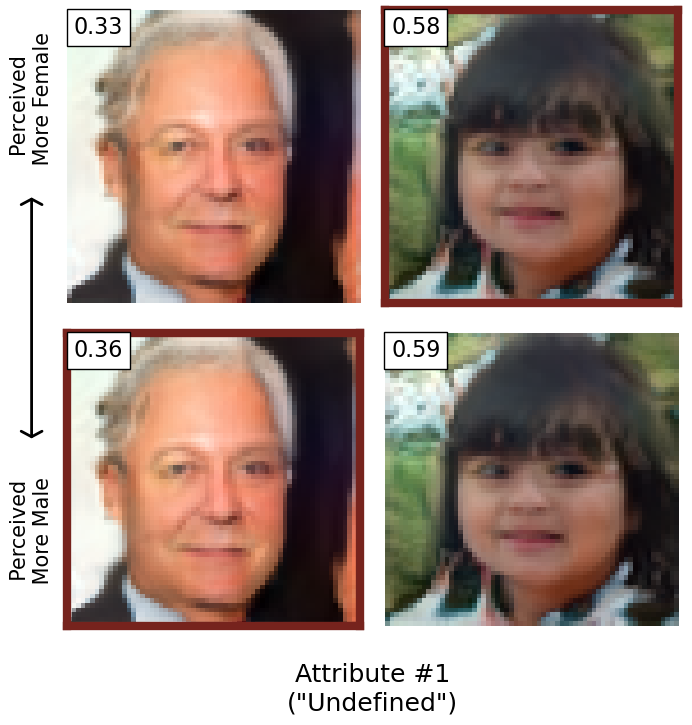

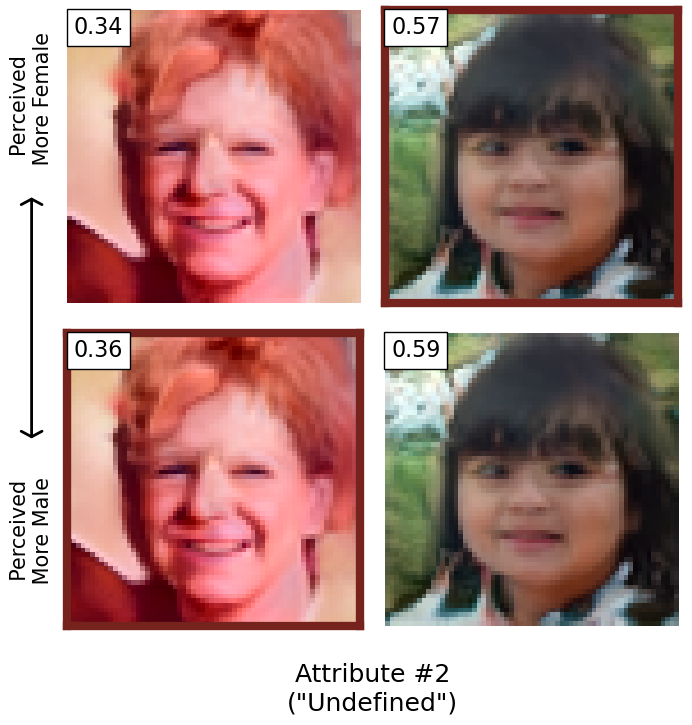

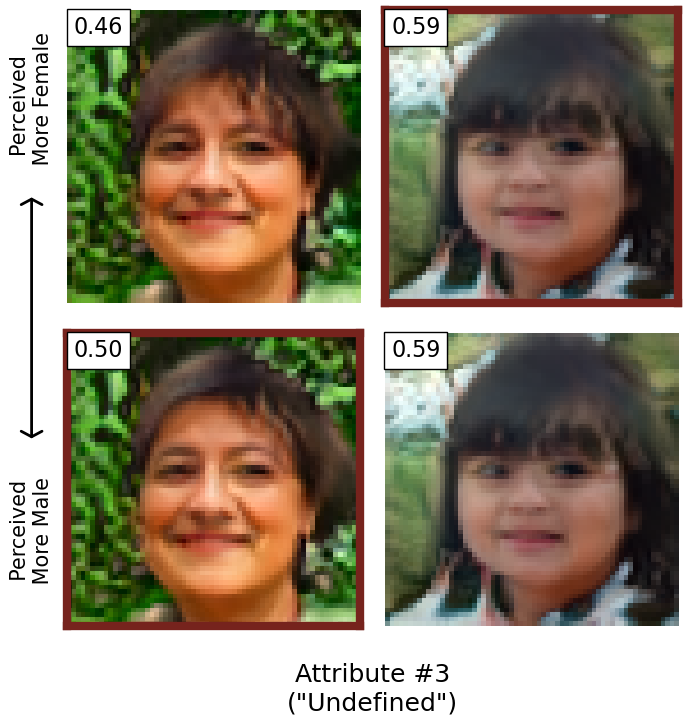

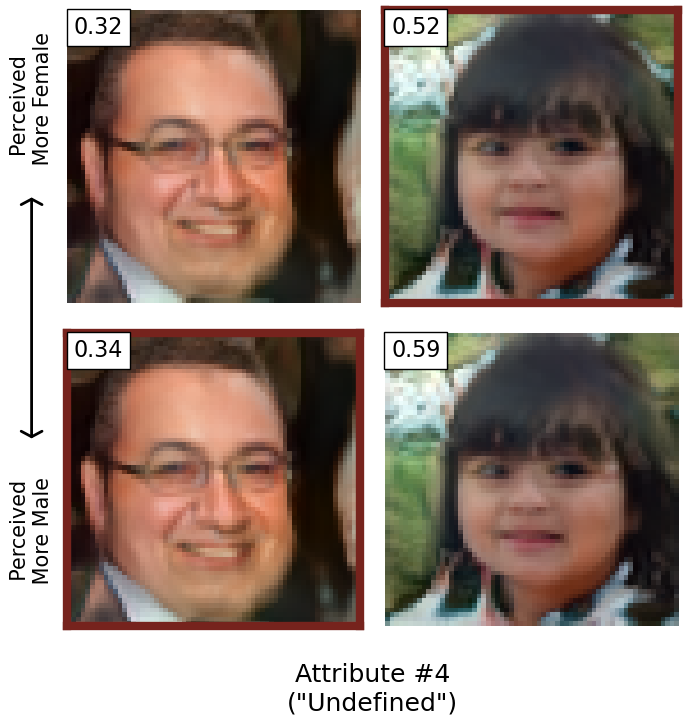

In [38]:
top_attribute_dir = "./top_attributes_figures"

if not os.path.exists(top_attribute_dir):
    os.makedirs(top_attribute_dir)

images_to_render, probs = show_top_attributes(stylex = stylex,
                                    classifier = classifier,
                                    s_indices_and_signs = s_indices_and_signs,
                                    W_values = W_values,
                                    style_change_effect = style_change_effect,
                                    base_probs = base_probs,
                                    style_min = style_min,
                                    style_max = style_max,
                                    noise = saved_noise,
                                    random_images=False,
                                    indices=None,
                                    shift_size = shift_size,
                                    return_probabilities=True,
                                    top_attribute_dir = top_attribute_dir,
                                    stylex_path = stylex_path)

# **Let's flip!**

In [36]:
def create_counterfactual(indices_and_signs,
                          generator,
                          flip,
                          style_coords,
                          style_min,
                          style_max,
                          shift_size,
                          w_latent_tensor,
                          noise):
    
    one_hot_shifts = []
    
    for direction, style_index in indices_and_signs:

        block_idx, weight_idx = sindex_to_block_idx_and_index(generator, style_index)
        block = generator.blocks[block_idx]

        if weight_idx < block.input_channels:
            current_style_layer = block.to_style1
            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
        else:
            weight_idx -= block.input_channels
            current_style_layer = block.to_style2
            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

        one_hot[:, weight_idx] = 1

        if (direction == 0 and flip == False) or (direction == 1 and flip == True):
            shift = one_hot * ((style_min[style_index] - style_coords[:, style_index]) * shift_size).unsqueeze(1)

        elif (direction == 1 and flip == False) or (direction == 0 and flip == True):
            shift = one_hot * ((style_max[style_index] - style_coords[:, style_index]) * shift_size).unsqueeze(1)

        shift = shift.squeeze(0)
        one_hot_shifts.append(shift)
        current_style_layer.bias += shift

    changed_image, _ = generator(w_latent_tensor, noise, get_style_coords=True)
    changed_prob = classifier.classify_images(changed_image)
    changed_prob = changed_prob.cpu().detach().numpy()

    for shift_index, (_, style_index) in enumerate(indices_and_signs):
        block_idx, weight_idx = sindex_to_block_idx_and_index(generator, style_index)
        block = generator.blocks[block_idx]

        if weight_idx < block.input_channels:
            current_style_layer = block.to_style1
        else:
            weight_idx -= block.input_channels
            current_style_layer = block.to_style2

        current_style_layer.bias -= one_hot_shifts[shift_index]
    
    return changed_image, changed_prob

In [ ]:
def flip_signs(num_attributes,
               stylex,
               classifier,
               s_indices_and_signs,
               W_values,
               base_probs,
               style_min,
               style_max,
               noise,
               shift_size,
               cuda_rank = 0,
               label_size = 2):
    
    flip_count = 0
    
    with torch.no_grad():
        
        generator = stylex.G
        indices_and_signs = s_indices_and_signs[0:num_attributes]
        
        for index, latent in enumerate(W_values):
            
            latent = [(torch.unsqueeze(torch.Tensor(latent).cuda(cuda_rank), 0), 5)]
            w_latent_tensor = styles_def_to_tensor(latent)
            _, style_coords = stylex.G(w_latent_tensor, noise, get_style_coords=True)
            
            gender = np.argmax(base_probs[index])
            flip = True if gender == 0 else False
            
            _, changed_prob = create_counterfactual(indices_and_signs = indices_and_signs,
                                                                  generator = generator,
                                                                  flip = flip,
                                                                  style_coords = style_coords,
                                                                  style_min = style_min,
                                                                  style_max = style_max,
                                                                  shift_size = shift_size,
                                                                  w_latent_tensor = w_latent_tensor,
                                                                  noise = noise)
            
            if np.argmax(base_probs[index]) != np.argmax(changed_prob):
                flip_count += 1
    
    flip_percentage = format(flip_count / len(base_probs), '.2f')
    print("Out of %s images, %s were flipped to the other class, using %s attributes \nand a shift_size of %s. This results in a percentage of %s" % (len(base_probs),
                                                                                                                               flip_count,
                                                                                                                               num_attributes,
                                                                                                                               shift_size,
                                                                                                                               flip_percentage))
    return flip_percentage

In [ ]:
stylex, classifier = model_loader(stylex_path = stylex_path,
                                  classifier_name = classifier_name,
                                  image_size = image_size,
                                  cuda_rank = cuda_rank)

flip_percentage = flip_signs(num_attributes=4,
                   stylex=stylex,
                   classifier = classifier,
                   s_indices_and_signs = s_indices_and_signs,
                   W_values = W_values,
                   base_probs = base_probs,
                   style_min = style_min,
                   style_max = style_max,
                   noise = saved_noise,
                   shift_size = shift_size)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Out of 101 images, 54 were flipped to the other class, using 10 attributes 
and a shift_size of 2. This results in a percentage of 0.53


# **Frechet Inception Distance**

In [29]:
fid_images = "./fid_images"
original_dir = os.path.join(fid_images, "original_images")
generated_dir = os.path.join(fid_images, "generated_images")
counterfactual_dir = os.path.join(fid_images, "counterfactual_images")
fids_results_filepath = "./fid_results.csv"

if not os.path.exists(fid_images):
    os.mkdir(fid_images)
    os.mkdir(original_dir)
    os.mkdir(generated_dir)
    os.mkdir(counterfactual_dir)
    
def save_tensor_image(folder, dataset):
    for index, image in enumerate(dataset):
        save_image(image, os.path.join(folder, 'image' + str(index) + '.png'))

def save_fids(fids, fids_results_filepath):
    num_fids = len(fids)
    column_names = ["Original-Generated"] + ["Original-Attribute 1"] + ["Original-Attributes 1-" + str(i) for i in range(2, num_fids)]
    data = {column_names[i]:[format(fids[i], '.2f')] for i in range(num_fids)}
    df = pd.DataFrame(data)
    df.to_csv(fids_results_filepath) 

In [30]:
def create_dataset(num_attributes,
               stylex,
               classifier,
               s_indices_and_signs,
               W_values,
               base_probs,
               style_min,
               style_max,
               noise,
               shift_size,
               cuda_rank = 0,
               label_size = 2,
               counterfactual_mode=False):
    
    with torch.no_grad():
        
        generator = stylex.G
        indices_and_signs = s_indices_and_signs[0:num_attributes]
        generated_images = []
        counterfactual_images = []
        
        for index, latent in enumerate(W_values):
            
            latent = [(torch.unsqueeze(torch.Tensor(latent).cuda(cuda_rank), 0), 5)]
            w_latent_tensor = styles_def_to_tensor(latent)
            generated_image, style_coords = stylex.G(w_latent_tensor, noise, get_style_coords=True)
            
            if counterfactual_mode:
                gender = np.argmax(base_probs[index])
                flip = True if gender == 0 else False

                counterfactual_image, _  = create_counterfactual(indices_and_signs = indices_and_signs,
                                                                  generator = generator,
                                                                  flip = flip,
                                                                  style_coords = style_coords,
                                                                  style_min = style_min,
                                                                  style_max = style_max,
                                                                  shift_size = shift_size,
                                                                  w_latent_tensor = w_latent_tensor,
                                                                  noise = noise)
                counterfactual_images.extend(counterfactual_image)
            generated_images.extend(generated_image)
    
    generated_dataset = torch.stack(generated_images)
    
    if counterfactual_mode:
        counterfactual_dataset = torch.stack(counterfactual_images)
        return generated_dataset, counterfactual_dataset
    else:
        return generated_dataset

In [31]:
def compute_fids(original_dir,
               generated_dir,
               counterfactual_dir,
               num_attributes=10,
               stylex=stylex,
               classifier = classifier,
               s_indices_and_signs = s_indices_and_signs,
               W_values = W_values,
               base_probs = base_probs,
               style_min = style_min,
               style_max = style_max,
               noise = saved_noise,
               shift_size = 1,
               counterfactual_mode=True,
               cuda_rank = cuda_rank):
    
    fids = []
    
    fid_original_generated = calculate_fid_given_paths([original_dir, generated_dir], batch_size=50, device=cuda_rank, dims=2048)
    fids.append(fid_original_generated)
    
    for i in range(num_attributes):
        _, counterfactual_dataset = create_dataset(num_attributes=i+1,
                                   stylex=stylex,
                                   classifier = classifier,
                                   s_indices_and_signs = s_indices_and_signs,
                                   W_values = W_values,
                                   base_probs = base_probs,
                                   style_min = style_min,
                                   style_max = style_max,
                                   noise = saved_noise,
                                   shift_size = shift_size,
                                   counterfactual_mode=True)
        
        save_tensor_image(counterfactual_dir, counterfactual_dataset)
        
        fid_counterfactual = calculate_fid_given_paths([original_dir, counterfactual_dir], batch_size=50, device=cuda_rank, dims=2048)
        fids.append(fid_counterfactual)
    
    return fids

In [32]:
stylex, classifier = model_loader(stylex_path = stylex_path,
                                  classifier_name = classifier_name,
                                  image_size = image_size,
                                  cuda_rank = cuda_rank)

original_dataset = torch.Tensor((np.copy(original_images))).cuda(cuda_rank)
save_tensor_image(original_dir, original_dataset)

generated_dataset = create_dataset(num_attributes=0,
                       stylex=stylex,
                       classifier = classifier,
                       s_indices_and_signs = s_indices_and_signs,
                       W_values = W_values,
                       base_probs = base_probs,
                       style_min = style_min,
                       style_max = style_max,
                       noise = saved_noise,
                       shift_size = shift_size,
                       counterfactual_mode=False)
save_tensor_image(generated_dir, generated_dataset)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
fids = compute_fids(original_dir, generated_dir, counterfactual_dir)
save_fids(fids, fids_results_filepath)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:06<00:00, 14.3MB/s]


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


NameError: name 'create_counterfactual' is not defined

NameError: name 'fids' is not defined

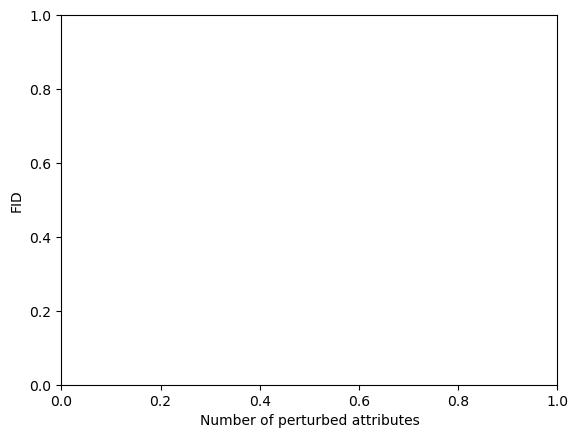

In [34]:
plt.xlabel('Number of perturbed attributes')
plt.ylabel('FID')
plt.plot(range(len(fids)), fids)
plt.show()